# Experiment of ordering classes for Class IL

Base on the confusion matrix from joint training we would like to check how ordering of classes: 
 - most confusing 
 - less confusion 
is affecting class incremental learning process 

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import sys
sys.path.append('../src/')

In [4]:
import torch
import numpy as np

In [58]:
from networks.resnet32 import resnet32
from networks.network import LLL_Net
from networks import tvmodels, set_tvmodel_head_var
from datasets.data_loader import get_datasets
import matplotlib.pyplot as plt
import seaborn as sns, numpy as np
import pandas as pd

In [6]:
from utils import seed_everything
SEED = 2
seed_everything(SEED)

## Loading the model 

ResNet32 trained on whole dataset.

The best I could get using our fremework without modification is around 66% accuracy. 

Parameters used for training: 

```
    args_line = "--exp_name confusion_matrix_2 --approach joint --datasets cifar100 "
    args_line += "--lr 0.1 --network resnet32 --num_tasks 1 --nepochs 200 --seed 2 --batch_size 128 "
    args_line += "--momentum 0.9 --weight_decay 5e-4 --lr_patience 15 --lr_factor 10 --lr_min 0.000001"
```    

In [7]:
init_model = resnet32()

In [8]:
MODEL_FILE = f'/data/experiments/LLL/cifar100_joint_confusion_matrix_{SEED}/models/task0.ckpt'

model = LLL_Net(init_model, remove_existing_head=True)
model.add_head(100)
model.load_state_dict(torch.load(MODEL_FILE))

<All keys matched successfully>

## Evaluate and get confustion matrix

In [9]:
from torchvision.datasets.cifar import CIFAR100
from datasets.dataset_config import dataset_config
from datasets.data_loader import get_loaders

# Loaders
seed_everything(SEED)
trn_loader, val_loader, tst_loader, taskcla = get_loaders(['cifar100'], 1, None, 128, num_workers=4, pin_memory=False)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
from torchvision.datasets.cifar import CIFAR100
cifar100_test = CIFAR100('/data/datasets/cifar100/', train=False, download=True)

Extracting /data/datasets/cifar100/cifar-100-python.tar.gz to /data/datasets/cifar100/


change the ordering of classes to one used in survey framework

In [14]:
classes_names = np.array(cifar100_test.classes)[trn_loader[0].dataset.class_indices]

In [15]:
cifar100_coarse_labels = np.array([
    'aquatic mammals',
    'fish',
    'flowers',
    'food containers',
    'fruit and vegetables',
    'household electrical devices',
    'household furniture',
    'insects',
    'large carnivores',
    'large man-made outdoor things',
    'large natural outdoor scenes',
    'large omnivores and herbivores',
    'medium-sized mammals',
    'non-insect invertebrates',
    'people',
    'reptiles',
    'small mammals',
    'trees',
    'vehicles 1',
    'vehicles 2'])

cifar100_fine_labels = [
    'beaver', 'dolphin', 'otter', 'seal', 'whale',
    'aquarium_fish', 'flatfish', 'ray', 'shark', 'trout',
    'orchid', 'poppy', 'rose', 'sunflower', 'tulip',
    'bottle', 'bowl', 'can', 'cup', 'plate',
    'apple', 'mushroom', 'orange', 'pear', 'sweet_pepper',
    'clock', 'keyboard', 'lamp', 'telephone', 'television',
    'bed', 'chair', 'couch', 'table', 'wardrobe',
    'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach',
    'bear', 'leopard', 'lion', 'tiger', 'wolf',
    'bridge', 'castle', 'house', 'road', 'skyscraper',
    'cloud', 'forest', 'mountain', 'plain', 'sea',
    'camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo',
    'fox', 'porcupine', 'possum', 'raccoon', 'skunk',
    'crab', 'lobster', 'snail', 'spider', 'worm',
    'baby', 'boy', 'girl', 'man', 'woman',
    'crocodile', 'dinosaur', 'lizard', 'snake', 'turtle',
    'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel',
    'maple_tree', 'oak_tree', 'palm_tree', 'pine_tree', 'willow_tree',
    'bicycle', 'bus', 'motorcycle', 'pickup_truck', 'train',
    'lawn_mower', 'rocket', 'streetcar', 'tank', 'tractor']

In [16]:
classes_group_idx = np.array([cifar100_fine_labels.index(n) // 5 for n in classes_names])
classes_group = cifar100_coarse_labels[classes_group_idx]

In [17]:
list(zip(classes_names, classes_group))

[('sweet_pepper', 'fruit and vegetables'),
 ('dolphin', 'aquatic mammals'),
 ('palm_tree', 'trees'),
 ('cockroach', 'insects'),
 ('can', 'food containers'),
 ('cloud', 'large natural outdoor scenes'),
 ('baby', 'people'),
 ('crocodile', 'reptiles'),
 ('cup', 'food containers'),
 ('bus', 'vehicles 1'),
 ('worm', 'non-insect invertebrates'),
 ('tulip', 'flowers'),
 ('skyscraper', 'large man-made outdoor things'),
 ('butterfly', 'insects'),
 ('apple', 'fruit and vegetables'),
 ('chimpanzee', 'large omnivores and herbivores'),
 ('bear', 'large carnivores'),
 ('dinosaur', 'reptiles'),
 ('plate', 'food containers'),
 ('spider', 'non-insect invertebrates'),
 ('girl', 'people'),
 ('boy', 'people'),
 ('table', 'household furniture'),
 ('lizard', 'reptiles'),
 ('shark', 'fish'),
 ('bed', 'household furniture'),
 ('couch', 'household furniture'),
 ('snail', 'non-insect invertebrates'),
 ('shrew', 'small mammals'),
 ('poppy', 'flowers'),
 ('rabbit', 'small mammals'),
 ('aquarium_fish', 'fish'),
 (

In [18]:
train_ds = trn_loader[0].dataset
idx2orig = train_ds.class_indices

In [19]:
from torchvision.utils import make_grid

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 crab
1 butterfly
2 whale
3 road
4 snake
5 ray
6 shrew
7 telephone


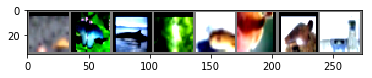

In [20]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trn_loader[0])
images, labels = next(dataiter)

imshow(make_grid(images[:8]))
for i in range(8): 
    print(i, classes_names[labels[i].item()])

In [27]:
n_all = 0
n_correct = 0
nb_classes = 100
confusion_matrix = torch.zeros(nb_classes, nb_classes)

model.cuda()
model.eval()
with torch.no_grad():
    for i, (inputs, labels) in enumerate(tst_loader[0]):
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = model(inputs)
        assert len(outputs) == 1
        outputs = outputs[0]
        preds = outputs.argmax(1)
        n_all += labels.size(0)
        n_correct += sum(preds == labels).item()
        for t, p in zip(labels.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

Model accuracy: 

In [28]:
n_correct / n_all

0.6635

In [29]:
group_color = ['red', 'green', 'blue', 'cyan', 'navy', 'magenta', 'limegreen', 'pink', 'violet', 'orange', 
               'mediumpurple', 'midnightblue', 'cornsilk', 'paleturquoise', 'bisque', 'slategray', 'darkcyan', 'khaki', 
               'wheat', 'teal'
              ]
class_colors = [group_color[i] for i in classes_group_idx]

In [30]:
# per-class accuracy
# with sns.axes_style("white"):
df = pd.DataFrame({"label" : classes_names,
                   "y" : (confusion_matrix.diag() / confusion_matrix.sum(1)).cpu().numpy(),
                   "z" : classes_group})

In [31]:
df

,label,y,z
0,sweet_pepper,0.53,fruit and vegetables
1,dolphin,0.54,aquatic mammals
2,palm_tree,0.81,trees
3,cockroach,0.79,insects
4,can,0.65,food containers
...,...,...,...
95,lion,0.59,large carnivores
96,clock,0.71,household electrical devices
97,seal,0.29,aquatic mammals
98,camel,0.71,large omnivores and herbivores


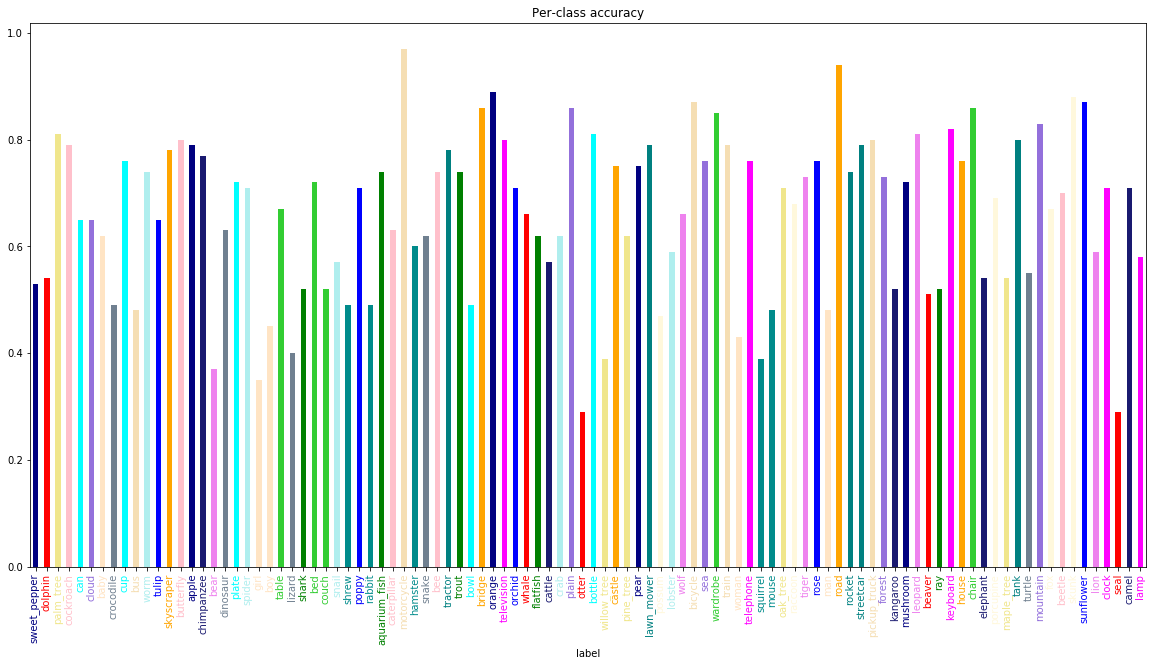

In [33]:
ax = df.set_index(['label']).y.plot.bar(figsize=(20,10), title='Per-class accuracy', color=class_colors)    

for xtick, color in zip(ax.get_xticklabels(), class_colors): 
        xtick.set_color(color); #ytick.set_color(color);

In [34]:
list(zip(cifar100_coarse_labels, group_color))

[('aquatic mammals', 'red'),
 ('fish', 'green'),
 ('flowers', 'blue'),
 ('food containers', 'cyan'),
 ('fruit and vegetables', 'navy'),
 ('household electrical devices', 'magenta'),
 ('household furniture', 'limegreen'),
 ('insects', 'pink'),
 ('large carnivores', 'violet'),
 ('large man-made outdoor things', 'orange'),
 ('large natural outdoor scenes', 'mediumpurple'),
 ('large omnivores and herbivores', 'midnightblue'),
 ('medium-sized mammals', 'cornsilk'),
 ('non-insect invertebrates', 'paleturquoise'),
 ('people', 'bisque'),
 ('reptiles', 'slategray'),
 ('small mammals', 'darkcyan'),
 ('trees', 'khaki'),
 ('vehicles 1', 'wheat'),
 ('vehicles 2', 'teal')]

In [35]:
cm = confusion_matrix.cpu().numpy()

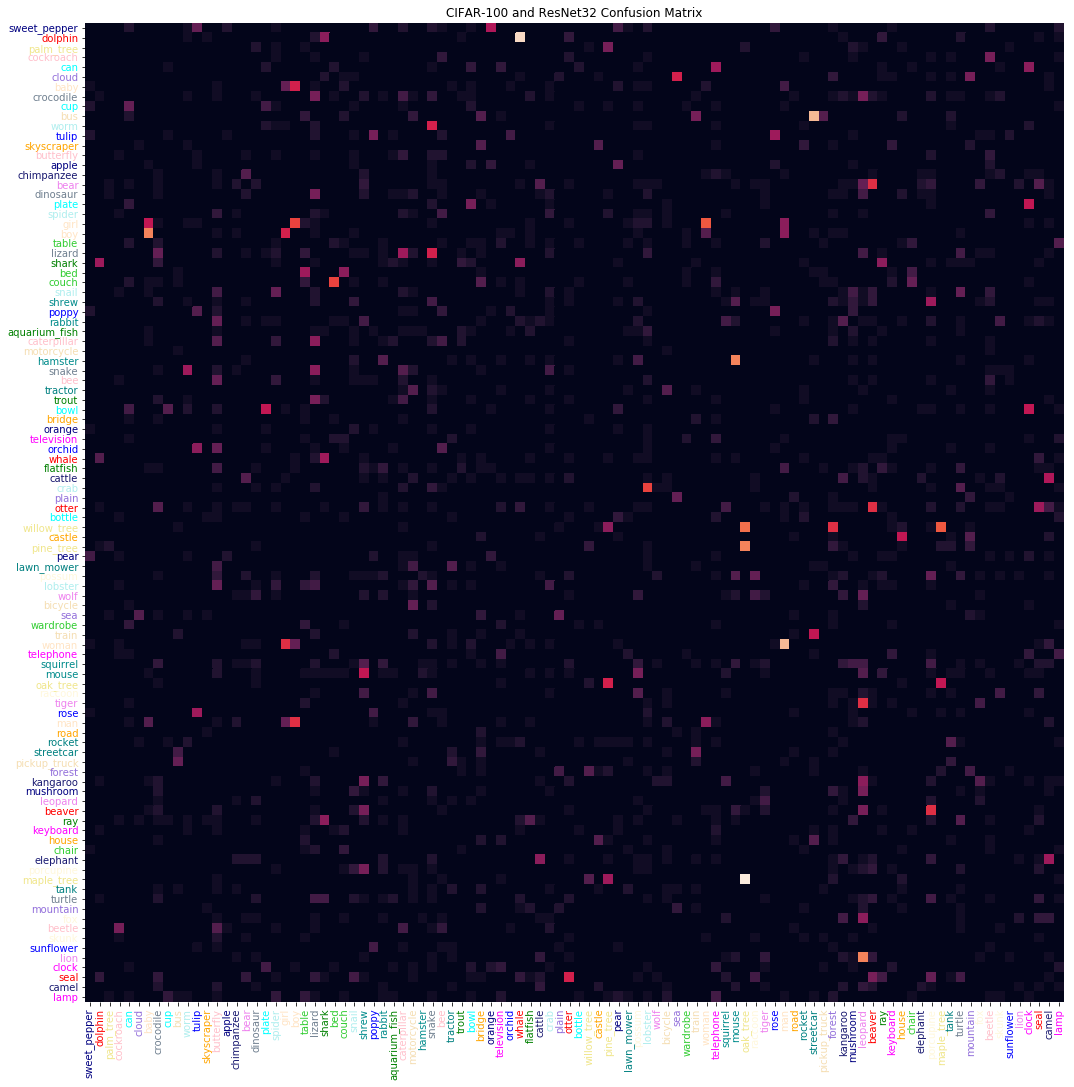

In [36]:
def apply_permutation(cm, perm):
    return cm[perm].transpose()[perm].transpose()


def plot_cm(cm, order = np.arange(100), log=False, title='CIFAR-100 and ResNet32 Confusion Matrix'):
    m = cm
    if log:
        m = np.log(m + 1)
    m[np.arange(m.shape[0]), np.arange(m.shape[1])] = 0
    m = apply_permutation(m, order)
    x = classes_names[order]
    plt.figure(figsize=(18,18))
    ax = sns.heatmap(m, xticklabels=x, yticklabels=x, square = True, cbar=False, )
    plt.title(title)
    for xtick, ytick, c_idx in zip(ax.get_xticklabels(), ax.get_yticklabels(), order): 
        xtick.set_color(class_colors[c_idx]); ytick.set_color(class_colors[c_idx]);
    
plot_cm(cm)

### order by coarse grained labels

In [37]:
groups_perm = [i for _, i in sorted([(classes_group_idx[i], i) for i in np.arange(100)])]

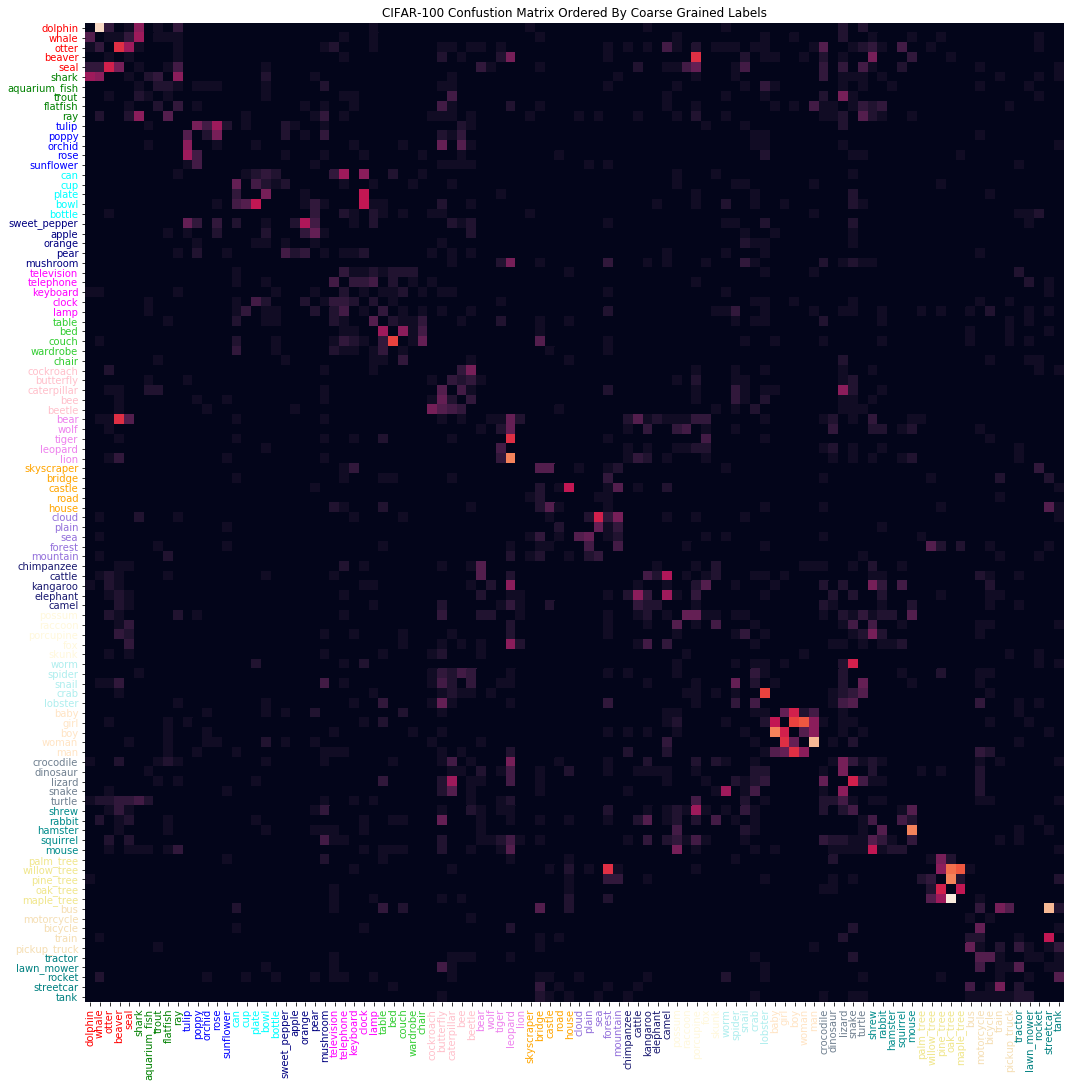

In [38]:
plot_cm(cm, order=groups_perm, title='CIFAR-100 Confustion Matrix Ordered By Coarse Grained Labels')

## Confustion Matrix Ordering

### Greedy approach

In [39]:
def cmo_greedy(m, classes_per_tasks=[10] * 10, max_confusion=True):
    m = m.copy()
    if max_confusion:
        m[np.arange(m.shape[0]), np.arange(m.shape[1])] = 0
    else: 
        m[np.arange(m.shape[0]), np.arange(m.shape[1])] = -m[np.arange(m.shape[0]), np.arange(m.shape[1])]
    print('Classes per tasks: ', classes_per_tasks)
    assert m.shape[0] == m.shape[1]
    assert sum(classes_per_tasks) == m.shape[0]
    solution = []
    # used_indices = set()
    i_start = 0
    for n_classes in classes_per_tasks:
        i_end = i_start + n_classes
        # predicion (col) vs true
        fp = m[:, i_start: i_end].sum(1).flatten()
        # true (row) vs pred
        fn = m[i_start: i_end, :].sum(0).flatten()
        fp = m.sum(1).flatten()
        # true (row) vs pred
        fn = m.sum(0).flatten()

        score = fp + fn
        order = score.argsort()
        if max_confusion:
            order = order[::-1] # desc
        # g = []
        n = 0
        for i in order:
            if i not in solution:
                solution.append(i)
                n += 1
                # used_indices.add(i)
                if n == n_classes:
                    break
                
        # solution.append(g)
        i_start = i_end
    return solution

In [40]:
splits = [20] * 5
split_max_confusion = np.array(cmo_greedy(cm, classes_per_tasks=splits))
split_min_confusion = np.array(cmo_greedy(cm, classes_per_tasks=splits, max_confusion=False))

Classes per tasks:  [20, 20, 20, 20, 20]
Classes per tasks:  [20, 20, 20, 20, 20]


In [41]:
split_max_confusion

array([23, 79, 35, 28, 97, 80, 49, 86, 13, 20, 71, 21,  7, 57, 66, 56, 89,
       32, 16, 63, 77, 30, 67, 76, 44, 24, 39, 65, 53, 81, 98,  6, 47, 51,
       96, 27, 26, 87, 22, 92, 46, 99, 64,  9,  1, 78, 74,  4, 11, 19, 17,
       36,  0, 45, 40, 25, 91, 18, 29, 85, 54, 68, 69, 42, 10, 83, 33, 70,
       95, 62, 37, 60, 34, 88, 90, 73, 82,  5, 52, 58, 38, 43, 31,  3, 59,
       15, 55,  8, 41, 75, 93, 84, 48, 12, 50, 14,  2, 61, 94, 72])

In [42]:
split_min_confusion

array([72, 94, 61,  2, 14, 50, 12, 48, 84, 93, 75, 41,  8, 55, 15, 59,  3,
       31, 43, 38, 58, 52,  5, 82, 73, 90, 88, 34, 60, 37, 62, 95, 70, 33,
       83, 10, 42, 69, 68, 54, 85, 29, 18, 91, 25, 40, 45,  0, 36, 17, 19,
       11,  4, 74, 78,  1,  9, 64, 99, 46, 92, 22, 87, 26, 27, 96, 51, 47,
        6, 98, 81, 53, 65, 39, 24, 44, 76, 67, 30, 77, 63, 16, 32, 89, 56,
       66, 57,  7, 21, 71, 20, 13, 86, 49, 80, 97, 28, 35, 79, 23])

## Find solution with simulated annealing

The similar problem is described here: 

https://cs.stackexchange.com/questions/70627/how-can-i-restructure-matrices-to-have-non-zero-elements-close-to-the-diagonal

as **Confusion Matrix Ordering (CMO)** problem.

where the author proposed a solution based on SA optimization. 
It was used in his mater thesis - page 48-50: 

https://arxiv.org/pdf/1707.09725.pdf


### Fitness function - our optimization goal

In [43]:
def calculate_weight_matrix(n):
    weights = np.abs(np.arange(n) - np.arange(n)[:, None])
    weights = np.array(weights, dtype=np.float)
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            weights[i][j] += (i + j) * 0.01
    return weights

def calculate_score(cm, weights):
    return int(np.tensordot(cm, weights, axes=((0, 1), (0, 1))))

This weight matrix will be used for weighting cm values. 

In this case, we would like to get results "along" the diagonal of cm matrix.

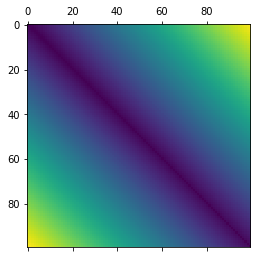

In [44]:
weights = calculate_weight_matrix(100)
plt.matshow(weights)

In [98]:
import random
from tqdm.autonotebook import tqdm

def swap(cm, i, j):
    """
    Swap row and column i and j in-place.
    Parameters
    ----------
    cm : ndarray
    i : int
    j : int
    Examples
    --------
    >>> cm = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8]])
    >>> swap(cm, 2, 0)
    array([[8, 7, 6],
           [5, 4, 3],
           [2, 1, 0]])
    """
    # swap columns
    copy = cm[:, i].copy()
    cm[:, i] = cm[:, j]
    cm[:, j] = copy
    # swap rows
    copy = cm[i, :].copy()
    cm[i, :] = cm[j, :]
    cm[j, :] = copy
    return cm


def move_1d(perm, from_start, from_end, insert_pos):
    """
    Move a block in a list.
    Parameters
    ----------
    perm : ndarray
        Permutation
    from_start : int
    from_end : int
    insert_pos : int
    Returns
    -------
    perm : ndarray
        The new permutation
    """
    if not (insert_pos < from_start or insert_pos > from_end):
        raise ValueError(
            "insert_pos={} needs to be smaller than from_start={}"
            " or greater than from_end={}".format(insert_pos, from_start, from_end)
        )
    if insert_pos > from_end:
        p_new = list(range(from_end + 1, insert_pos + 1)) + list(
            range(from_start, from_end + 1)
        )
    else:
        p_new = list(range(from_start, from_end + 1)) + list(
            range(insert_pos, from_start)
        )
    p_old = sorted(p_new)
    perm[p_old] = perm[p_new]
    return perm


def move(cm, from_start, from_end, insert_pos):
    """
    Move rows from_start - from_end to insert_pos in-place.
    Parameters
    ----------
    cm : ndarray
    from_start : int
    from_end : int
    insert_pos : int
    Returns
    -------
    cm : ndarray
    Examples
    --------
    >>> cm = np.array([[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 0, 1], [2, 3, 4, 5]])
    >>> move(cm, 1, 2, 0)
    array([[5, 6, 4, 7],
           [9, 0, 8, 1],
           [1, 2, 0, 3],
           [3, 4, 2, 5]])
    """
    if not (insert_pos < from_start or insert_pos > from_end):
        raise ValueError(
            "insert_pos={} needs to be smaller than from_start={}"
            " or greater than from_end={}".format(insert_pos, from_start, from_end)
        )
    if insert_pos > from_end:
        p_new = list(range(from_end + 1, insert_pos + 1)) + list(
            range(from_start, from_end + 1)
        )
    else:
        p_new = list(range(from_start, from_end + 1)) + list(
            range(insert_pos, from_start)
        )
    p_old = sorted(p_new)
    # swap columns
    cm[:, p_old] = cm[:, p_new]
    # swap rows
    cm[p_old, :] = cm[p_new, :]
    return cm


def swap_1d(perm, i, j):
    perm[i], perm[j] = perm[j], perm[i]
    return perm

def apply_permutation(cm, perm):
    return cm[perm].transpose()[perm].transpose()


def generate_permutation(n, current_perm, tmp_cm):
    """
    Generate a new permutation.
    Parameters
    ----------
    n : int
    current_perm : List[int]
    tmp_cm : np.ndarray
    Return
    ------
    perm, make_swap : List[int], bool
    """
    swap_prob = 0.5
    make_swap = random.random() < swap_prob
    if n < 3:
        # In this case block-swaps don't make any sense
        make_swap = True
    if make_swap:
        # Choose what to swap
        i = random.randint(0, n - 1)
        j = i
        while j == i:
            j = random.randint(0, n - 1)
        # Define permutation
        perm = swap_1d(current_perm.copy(), i, j)
        # Define values after swap
        tmp_cm = swap(tmp_cm, i, j)
    else:
        # block-swap
        block_len = n
        while block_len >= n - 1:
            from_start = random.randint(0, n - 3)
            from_end = random.randint(from_start + 1, n - 2)
            block_len = from_start - from_end
        insert_pos = from_start
        while not (insert_pos < from_start or insert_pos > from_end):
            insert_pos = random.randint(0, n - 1)
        perm = move_1d(current_perm.copy(), from_start, from_end, insert_pos)

        # Define values after swap
        tmp_cm = move(tmp_cm, from_start, from_end, insert_pos)
    return perm, make_swap


def simulated_annealing(
    current_cm,
    current_perm=None,
    score=calculate_score,
    steps=2 * 10 ** 5,
    temp=100.0,
    cooling_factor=0.99,
    deterministic=False,
    calculate_weight_matrix=calculate_weight_matrix
):
    """
    Optimize current_cm by randomly swapping elements.
    Parameters
    ----------
    current_cm : ndarray
    current_perm : None or iterable, optional (default: None)
    steps : int, optional (default: 2 * 10**4)
    temp : float > 0.0, optional (default: 100.0)
        Temperature
    cooling_factor: float in (0, 1), optional (default: 0.99)
    Returns
    -------
    best_result : Dict[str, Any]
        "best_cm"
        "best_perm"
    """
    if temp <= 0.0:
        raise ValueError("temp={} needs to be positive".format(temp))
    if cooling_factor <= 0.0 or cooling_factor >= 1.0:
        raise ValueError(
            "cooling_factor={} needs to be in the interval "
            "(0, 1)".format(cooling_factor)
        )
    n = len(current_cm)
    if current_perm is None:
        current_perm = list(range(n))
    current_perm = np.array(current_perm)

    # Pre-calculate weights
    weights = calculate_weight_matrix(n)

    # Apply the permutation
    current_cm = apply_permutation(current_cm, current_perm)
    current_score = score(current_cm, weights)

    best_cm = current_cm
    best_score = current_score
    best_perm = current_perm

    _scores=[]
    _scores_step = 1000
    
    # print("## Starting Score: {:0.2f}".format(current_score))
    pbar = tqdm(range(steps))
    for step in pbar:
        tmp_cm = np.array(current_cm, copy=True)
        perm, make_swap = generate_permutation(n, current_perm, tmp_cm)
        tmp_score = score(tmp_cm, weights)

        # Should be swapped?
        if deterministic:
            chance = 1.0
        else:
            chance = random.random()
            temp *= 0.99
        hot_prob_thresh = min(1, np.exp(-(tmp_score - current_score) / temp))
        if chance <= hot_prob_thresh:
            changed = False
            if best_score > tmp_score:  # minimize
                best_perm = perm
                best_cm = tmp_cm
                best_score = tmp_score
                changed = True
            current_score = tmp_score
            current_cm = tmp_cm
            current_perm = perm
            
            if changed:
                pbar.set_description("Current: %0.2f (best: %0.2f)" % (current_score, best_score))
#                 print(
#                     (
#                         "Current: %0.2f (best: %0.2f, "
#                         "hot_prob_thresh=%0.4f%%, step=%i, swap=%s)"
#                     ) % (
#                     current_score,
#                     best_score,
#                     (hot_prob_thresh * 100),
#                     step,
#                     str(make_swap)
#                 ))
        if step > _scores_step * 2 and step % _scores_step == 0:
            _scores.append(best_score)

    plt.figure()
    plt.plot(np.arange(len(_scores)) * _scores_step, _scores)
    plt.title('Optimization scrore')
    
    return {"cm": best_cm, "perm": best_perm, "scores": _scores}


/home/btwardow/miniconda3/envs/deep-learning/lib/python3.7/site-packages/ipykernel_launcher.py:223: RuntimeWarning: overflow encountered in exp


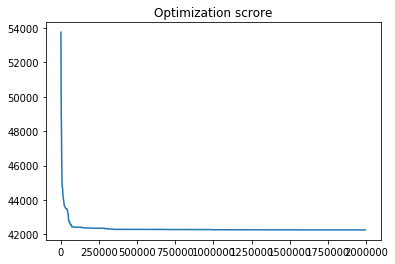

In [99]:
STEPS = 20 * 10 ** 5
# max confusion
r = simulated_annealing(cm.copy(), steps=STEPS)
split_max_confusion_sa = r['perm']
cm_max_sa = r['cm']

In [100]:
def calculate_score_min(cm, weights):
    return  -1 * int(np.tensordot(cm, weights, axes=((0, 1), (0, 1))))

/home/btwardow/miniconda3/envs/deep-learning/lib/python3.7/site-packages/ipykernel_launcher.py:223: RuntimeWarning: overflow encountered in exp


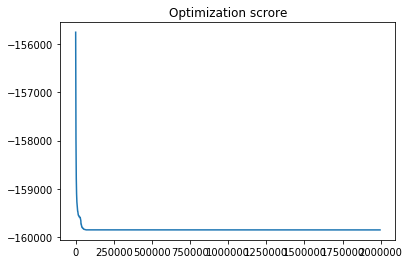

In [101]:
r = simulated_annealing(cm.copy(), steps=STEPS, score=calculate_score_min)
split_min_confusion_sa = r['perm']
cm_min_sa = r['cm']

In [102]:
calculate_weight_matrix(100).max()

99.99

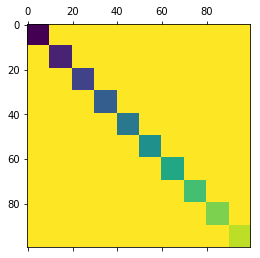

In [156]:
def calculate_weight_matrix_tasks(n, n_tasks=10):
    weights = np.ones((n, n)) * 99.9
    tc = int(nb_classes / n_tasks)
    for i_start in range(0, nb_classes, tc):
        i_end = i_start + tc
        weights[i_start:i_end, i_start:i_end] = i_start 
    return weights

plt.matshow(calculate_weight_matrix_tasks(100))

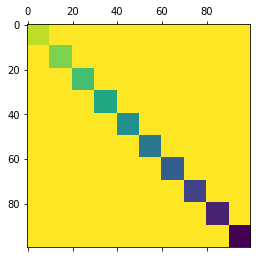

In [104]:
def calculate_weight_matrix_tasks2(n, n_tasks=10):
    weights = np.ones((n, n)) * 99.9
    tc = int(nb_classes / n_tasks)
    for i_start in range(0, nb_classes, tc):
        i_end = i_start + tc
        weights[i_start:i_end, i_start:i_end] = 100 - i_end
    return weights

plt.matshow(calculate_weight_matrix_tasks2(100))

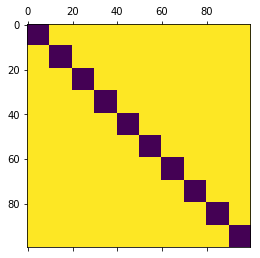

In [136]:
def calculate_weight_matrix_tasks3(n, n_tasks=10):
    weights = np.ones((n, n)) * 99.9
    tc = int(nb_classes / n_tasks)
    for i_start in range(0, nb_classes, tc):
        i_end = i_start + tc
        weights[i_start:i_end, i_start:i_end] = 0
    return weights

plt.matshow(calculate_weight_matrix_tasks3(100))

/home/btwardow/miniconda3/envs/deep-learning/lib/python3.7/site-packages/ipykernel_launcher.py:223: RuntimeWarning: overflow encountered in exp


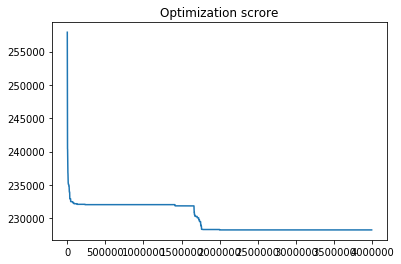

In [157]:
r = simulated_annealing(cm.copy(), steps=2* STEPS, calculate_weight_matrix=calculate_weight_matrix_tasks)
split_max_confusion_sa_tasks = r['perm']
cm_max_sa_tasks = r['cm']

/home/btwardow/miniconda3/envs/deep-learning/lib/python3.7/site-packages/ipykernel_launcher.py:223: RuntimeWarning: overflow encountered in exp


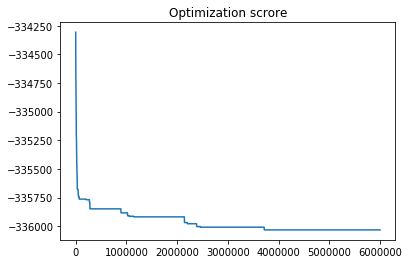

In [138]:
r = simulated_annealing(cm.copy(), steps=3* STEPS, score=calculate_score_min, calculate_weight_matrix=calculate_weight_matrix_tasks)
split_min_confusion_sa_tasks = r['perm']
cm_min_sa_tasks = r['cm']

/home/btwardow/miniconda3/envs/deep-learning/lib/python3.7/site-packages/ipykernel_launcher.py:223: RuntimeWarning: overflow encountered in exp


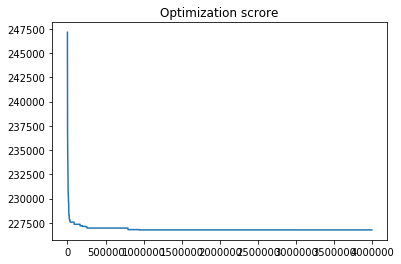

In [108]:
r = simulated_annealing(cm.copy(), steps=2* STEPS, calculate_weight_matrix=calculate_weight_matrix_tasks2)
split_inc_confusion_sa_tasks = r['perm']
cm_inc_sa_tasks = r['cm']

/home/btwardow/miniconda3/envs/deep-learning/lib/python3.7/site-packages/ipykernel_launcher.py:223: RuntimeWarning: overflow encountered in exp


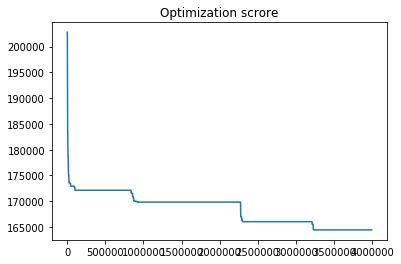

In [137]:
r = simulated_annealing(cm.copy(), steps=2* STEPS, calculate_weight_matrix=calculate_weight_matrix_tasks3)
split_eq_confusion_sa_tasks = r['perm']
cm_eq_sa_tasks = r['cm']

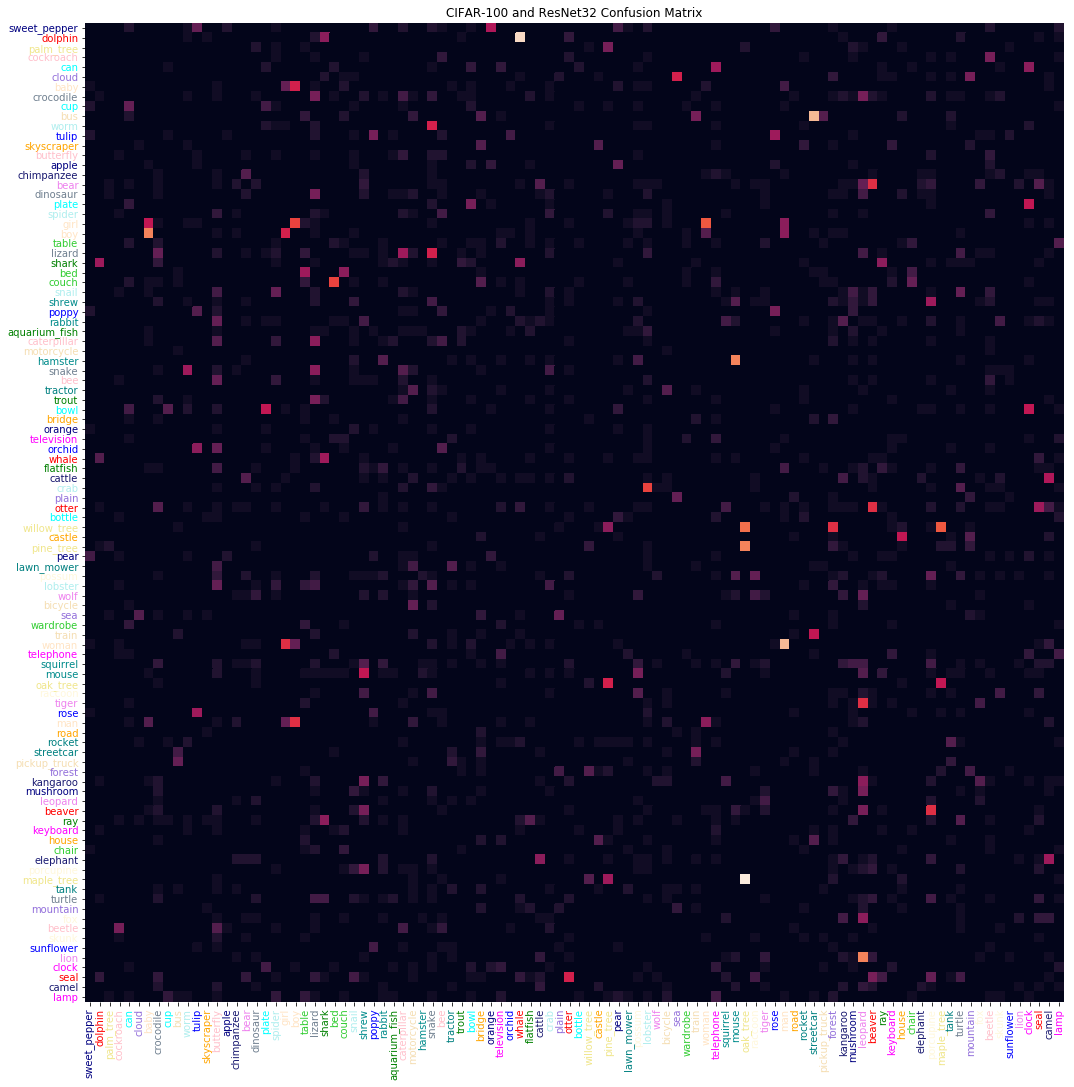

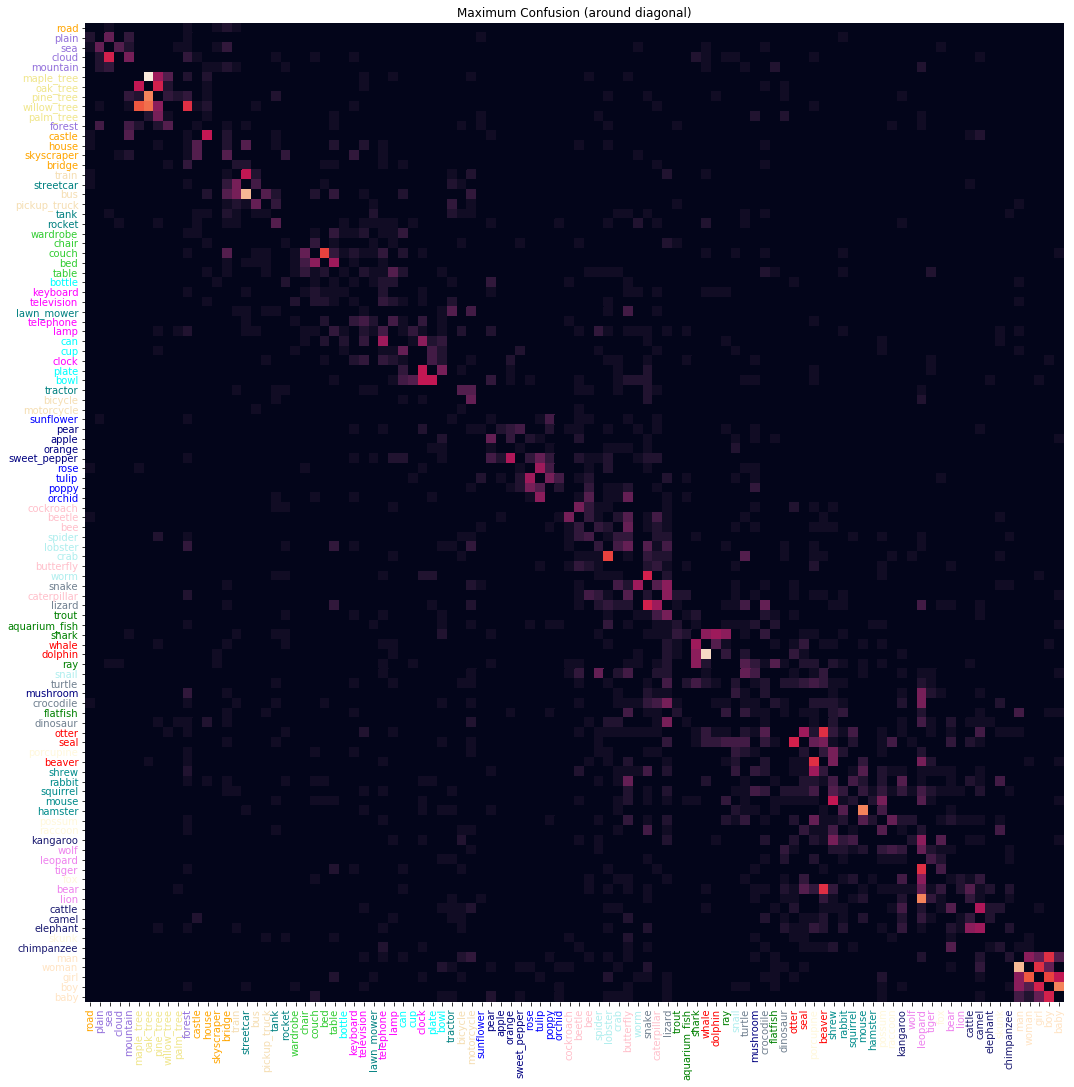

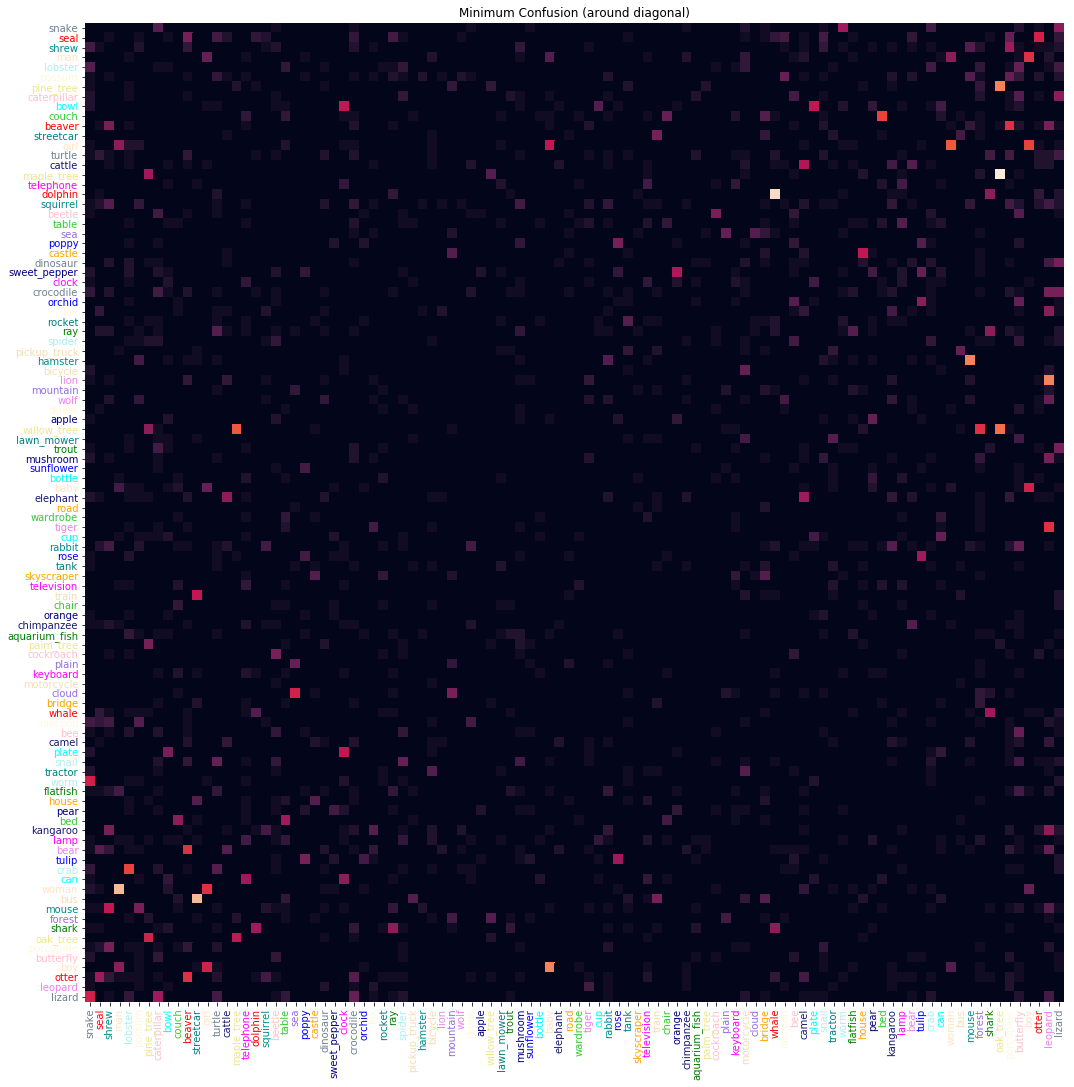

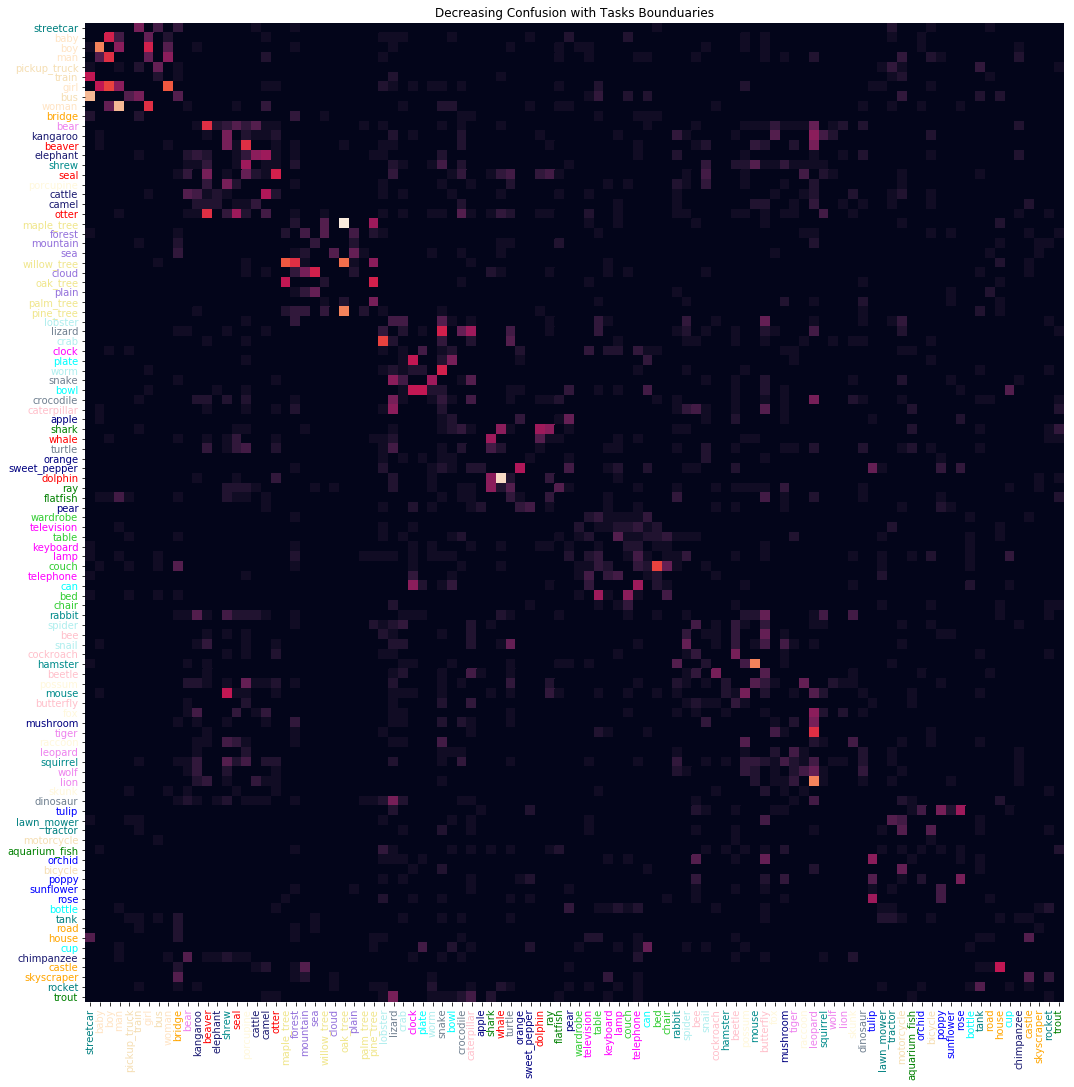

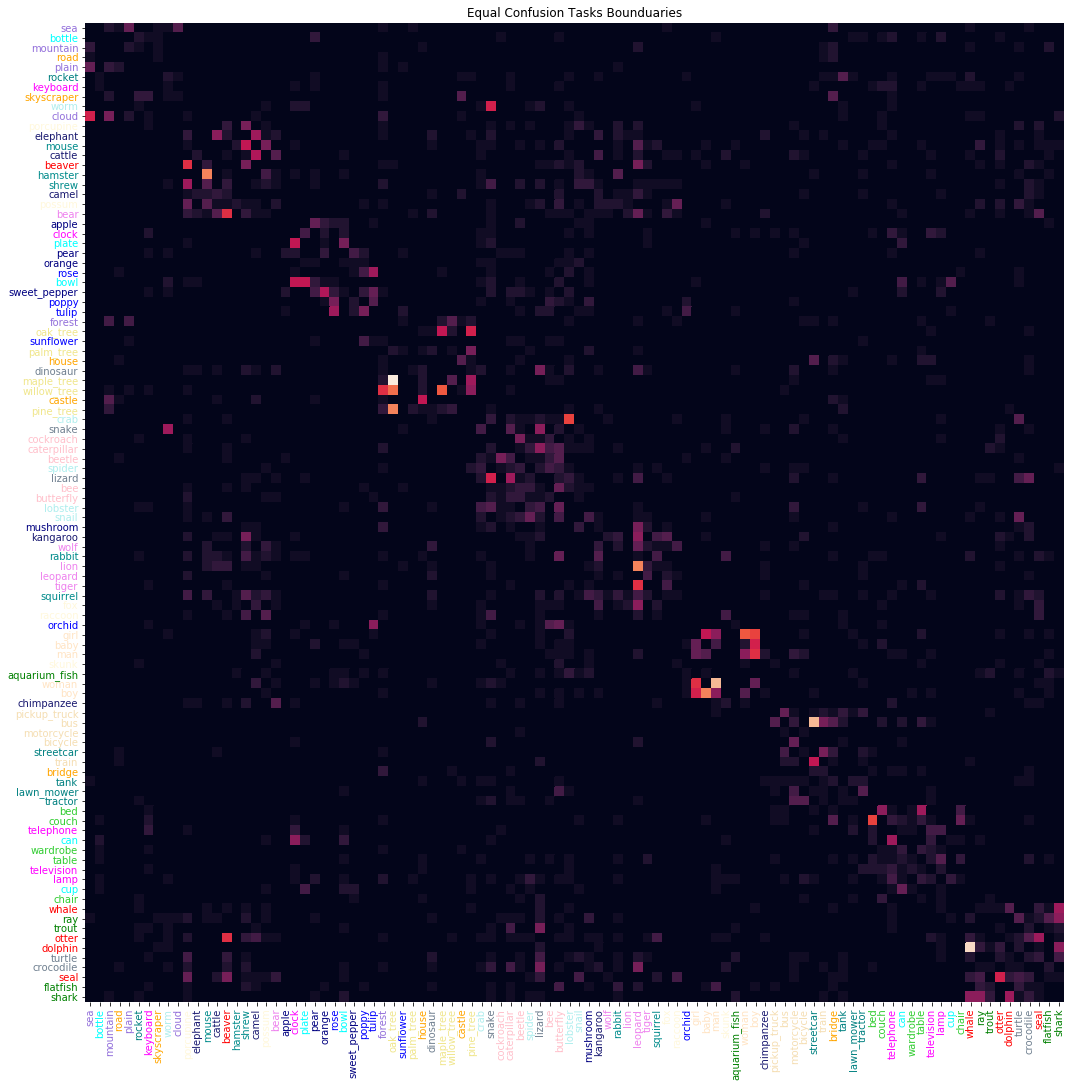

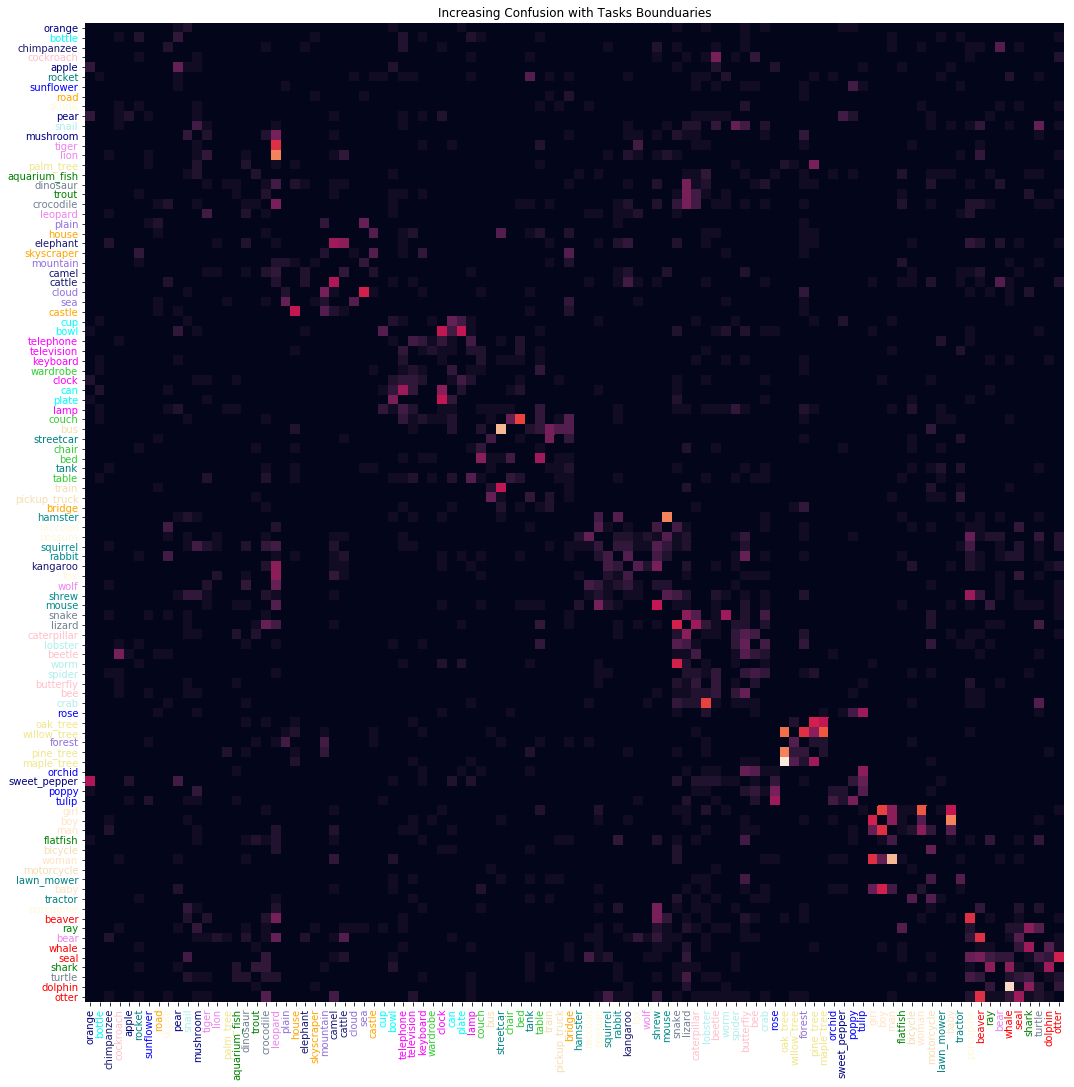

In [165]:
use_log = True
plot_cm(cm)
plot_cm(cm, order=split_max_confusion_sa, title = 'Maximum Confusion (around diagonal)')
plot_cm(cm, order=split_min_confusion_sa, title = 'Minimum Confusion (around diagonal)')
plot_cm(cm, order=split_max_confusion_sa_tasks, title = 'Decreasing Confusion with Tasks Bounduaries')
plot_cm(cm, order=split_eq_confusion_sa_tasks, title = 'Equal Confusion Tasks Bounduaries')
# plot_cm(cm, order=split_min_confusion_sa_tasks, title = 'Minimum Confusion with Tasks Bounduaries')
plot_cm(cm, order=split_inc_confusion_sa_tasks, title = 'Increasing Confusion with Tasks Bounduaries')

## Labels orders

In [166]:
print([train_ds.class_indices[i] for i in split_max_confusion_sa])

[68, 60, 71, 23, 49, 47, 52, 59, 96, 56, 33, 17, 37, 76, 12, 90, 81, 13, 58, 85, 69, 94, 20, 25, 5, 84, 9, 39, 87, 41, 86, 40, 16, 28, 22, 61, 10, 89, 8, 48, 82, 57, 0, 53, 83, 70, 92, 62, 54, 24, 7, 6, 79, 45, 26, 14, 99, 78, 18, 44, 91, 1, 73, 95, 30, 67, 77, 93, 51, 27, 32, 29, 55, 72, 63, 4, 74, 65, 80, 50, 36, 64, 66, 38, 97, 42, 88, 34, 3, 43, 19, 15, 31, 75, 21, 46, 98, 35, 11, 2]


In [160]:
print([train_ds.class_indices[i] for i in split_min_confusion_sa])

[78, 72, 74, 46, 45, 64, 59, 18, 10, 25, 4, 81, 35, 93, 19, 47, 86, 30, 80, 7, 84, 71, 62, 17, 29, 83, 22, 27, 54, 34, 69, 67, 79, 58, 36, 8, 43, 49, 97, 75, 0, 96, 41, 91, 51, 82, 9, 2, 31, 68, 94, 88, 28, 65, 70, 85, 76, 87, 90, 20, 53, 21, 1, 56, 24, 60, 39, 48, 23, 12, 95, 66, 6, 15, 61, 77, 89, 99, 32, 37, 57, 5, 38, 40, 3, 92, 26, 16, 98, 13, 50, 33, 73, 52, 63, 14, 11, 55, 42, 44]


In [161]:
print([train_ds.class_indices[i] for i in split_min_confusion_sa_tasks])

[70, 57, 87, 81, 59, 14, 35, 42, 72, 91, 24, 95, 88, 56, 1, 38, 78, 46, 94, 76, 12, 53, 6, 73, 21, 39, 40, 60, 48, 64, 11, 62, 19, 61, 23, 96, 86, 27, 79, 50, 63, 8, 69, 58, 36, 44, 37, 97, 83, 43, 65, 99, 17, 2, 66, 51, 16, 7, 29, 41, 9, 67, 26, 3, 5, 92, 52, 15, 33, 90, 98, 84, 93, 0, 31, 47, 18, 74, 22, 71, 28, 75, 80, 45, 30, 4, 25, 32, 85, 82, 68, 34, 13, 49, 20, 54, 10, 55, 89, 77]


In [162]:
print([train_ds.class_indices[i] for i in split_eq_confusion_sa_tasks])

[71, 9, 49, 68, 60, 69, 39, 76, 99, 23, 63, 31, 50, 19, 4, 36, 74, 15, 64, 3, 0, 22, 61, 57, 53, 70, 10, 83, 62, 92, 33, 52, 82, 56, 37, 29, 47, 96, 17, 59, 26, 78, 24, 18, 7, 79, 44, 6, 14, 45, 77, 51, 38, 97, 65, 43, 42, 88, 80, 34, 66, 54, 35, 2, 46, 75, 1, 98, 11, 21, 58, 13, 48, 8, 81, 90, 12, 85, 41, 89, 5, 25, 86, 16, 94, 84, 87, 40, 28, 20, 95, 67, 91, 55, 30, 93, 27, 72, 32, 73]


In [163]:
print([train_ds.class_indices[i] for i in split_max_confusion_sa_tasks])

[81, 2, 11, 46, 58, 90, 35, 13, 98, 12, 3, 38, 4, 31, 74, 72, 63, 19, 15, 55, 47, 33, 49, 71, 96, 23, 52, 60, 56, 59, 45, 44, 26, 22, 61, 99, 78, 10, 27, 18, 0, 73, 95, 93, 53, 83, 30, 67, 32, 57, 94, 87, 84, 39, 40, 25, 86, 16, 5, 20, 65, 79, 6, 77, 24, 36, 7, 64, 50, 14, 34, 51, 88, 66, 42, 80, 97, 43, 75, 29, 92, 41, 89, 48, 1, 54, 8, 62, 82, 70, 9, 85, 68, 37, 28, 21, 17, 76, 69, 91]


In [164]:
print([train_ds.class_indices[i] for i in split_inc_confusion_sa_tasks])

[53, 9, 21, 24, 0, 69, 82, 68, 75, 57, 77, 51, 88, 43, 56, 1, 29, 91, 27, 42, 60, 37, 31, 76, 49, 15, 19, 23, 71, 17, 28, 10, 86, 87, 39, 94, 22, 16, 61, 40, 25, 13, 81, 20, 5, 85, 84, 90, 58, 12, 36, 66, 64, 80, 65, 38, 34, 97, 74, 50, 78, 44, 18, 45, 7, 99, 79, 14, 6, 26, 70, 52, 96, 33, 59, 47, 54, 83, 62, 92, 35, 11, 46, 32, 8, 98, 48, 41, 2, 89, 63, 4, 67, 3, 95, 72, 73, 93, 30, 55]


# Run experiments on CIFAR-100

Experiments with FT: 
 - without ordering (random)
 - icarl ordering
 - max confusion 
 - min confusion

In [426]:
MODES = [
#     '', 
#     '_cm_max', 
#     '_cm_min', 
#     '_cm_max_tasks', 
#     '_cm_min_tasks', 
#     '_icarl',
    '_cm_inc_tasks'
]

# Fine Tunning

In [427]:
args_line = "--exp_name ordering_2_{seed} --approach {approach} --datasets cifar100{mode} "
args_line += "--lr 0.01 --network resnet32 --num_tasks 5 --nepochs 200 --seed {seed} --batch_size 128 "
args_line += "--momentum 0.9 --weight_decay 5e-4 --lr_patience 10 --lr_factor 10 --lr_min 0.000001 "
args_line += "--results_path ../results/ --num_exemplars 0"
print(args_line)

--exp_name ordering_2_{seed} --approach {approach} --datasets cifar100{mode} --lr 0.01 --network resnet32 --num_tasks 5 --nepochs 200 --seed {seed} --batch_size 128 --momentum 0.9 --weight_decay 5e-4 --lr_patience 10 --lr_factor 10 --lr_min 0.000001 --results_path ../results/ --num_exemplars 0


In [428]:
import runpy, os
os.getcwd()

'/home/btwardow/UAB-CVC-LAMP/IL_Survey/notebooks'

In [430]:
# os.chdir('../src')
# _argv = sys.argv

for approach in ['finetune', 'lwf']:
    print('=' * 50)
    print(approach)
    print('=' * 50)
    for mode in MODES:
        a = args_line.format(seed=SEED, mode=mode, approach=approach)
#         print('Runnning with args: ')
        print('python main_incremental.py', a)
#     sys.argv = ['main_incremental.py'] + a.split(' ')
#     runpy.run_path('main_incremental.py')

# os.chdir('../notebooks')
# sys.argv = _argv

finetune
python main_incremental.py --exp_name ordering_2_2 --approach finetune --datasets cifar100_cm_inc_tasks --lr 0.01 --network resnet32 --num_tasks 5 --nepochs 200 --seed 2 --batch_size 128 --momentum 0.9 --weight_decay 5e-4 --lr_patience 10 --lr_factor 10 --lr_min 0.000001 --results_path ../results/ --num_exemplars 0
lwf
python main_incremental.py --exp_name ordering_2_2 --approach lwf --datasets cifar100_cm_inc_tasks --lr 0.01 --network resnet32 --num_tasks 5 --nepochs 200 --seed 2 --batch_size 128 --momentum 0.9 --weight_decay 5e-4 --lr_patience 10 --lr_factor 10 --lr_min 0.000001 --results_path ../results/ --num_exemplars 0


In [431]:
avg_acc = {}
acc = {}
forg = {}

for w in os.walk('../results'):
    if w[0].endswith('_ordering_2_2/results') and len(w[1]) == 0 :
        n = w[0].split('/')[2]
        for f in w[2]:
            with open(f'{w[0]}/{f}', 'rt') as _f:
                m = [[float(v) for v in l.split('\t')] for l in _f.readlines()]
                if f.startswith('acc_tag'):
                    acc[n] = m
                if f.startswith('forg_tag'):
                    forg[n] = m
                if f.startswith('avg_accs_tag'):
                    avg_acc[n] = m[0]

## Average accuracy

<Figure size 432x288 with 0 Axes>

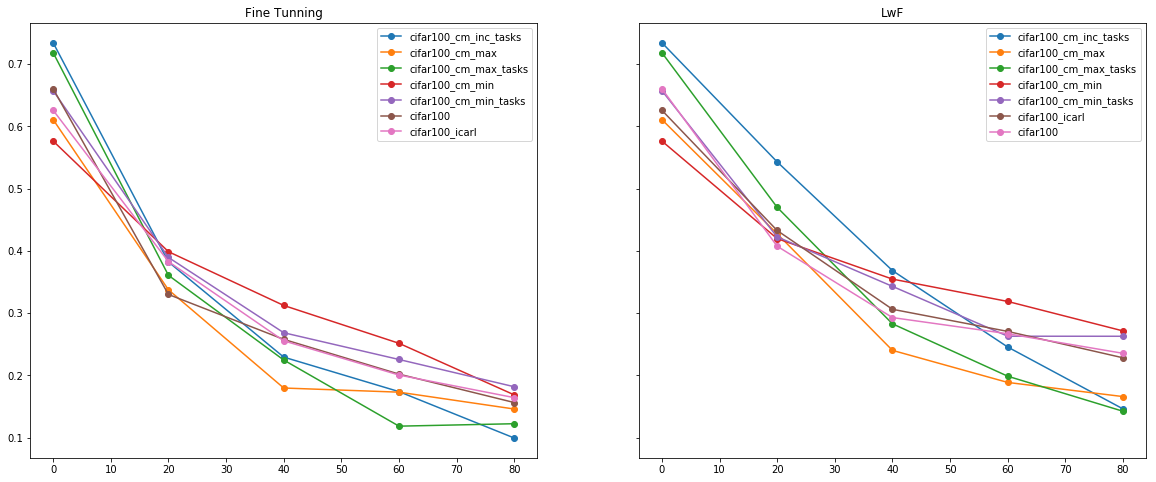

In [432]:
plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20, 8))

ft = sorted([(n, v) for n,v in avg_acc.items() if 'finetune' in n])
lwf = sorted([(n, v) for n,v in avg_acc.items() if 'lwf' in n])

for n, m in ft:
    ax1.plot(np.arange(len(m)) * 20, m, '-o', label=n.split('_finetune_ordering_2_2')[0])

for n, m in lwf:
    ax2.plot(np.arange(len(m)) * 20, m, '-o', label=n.split('_lwf_ordering_2_2')[0])
    
ax1.legend()
ax1.set_title('Fine Tunning')
ax2.legend()
ax2.set_title('LwF')
plt.show()

## Tasks Accuracies

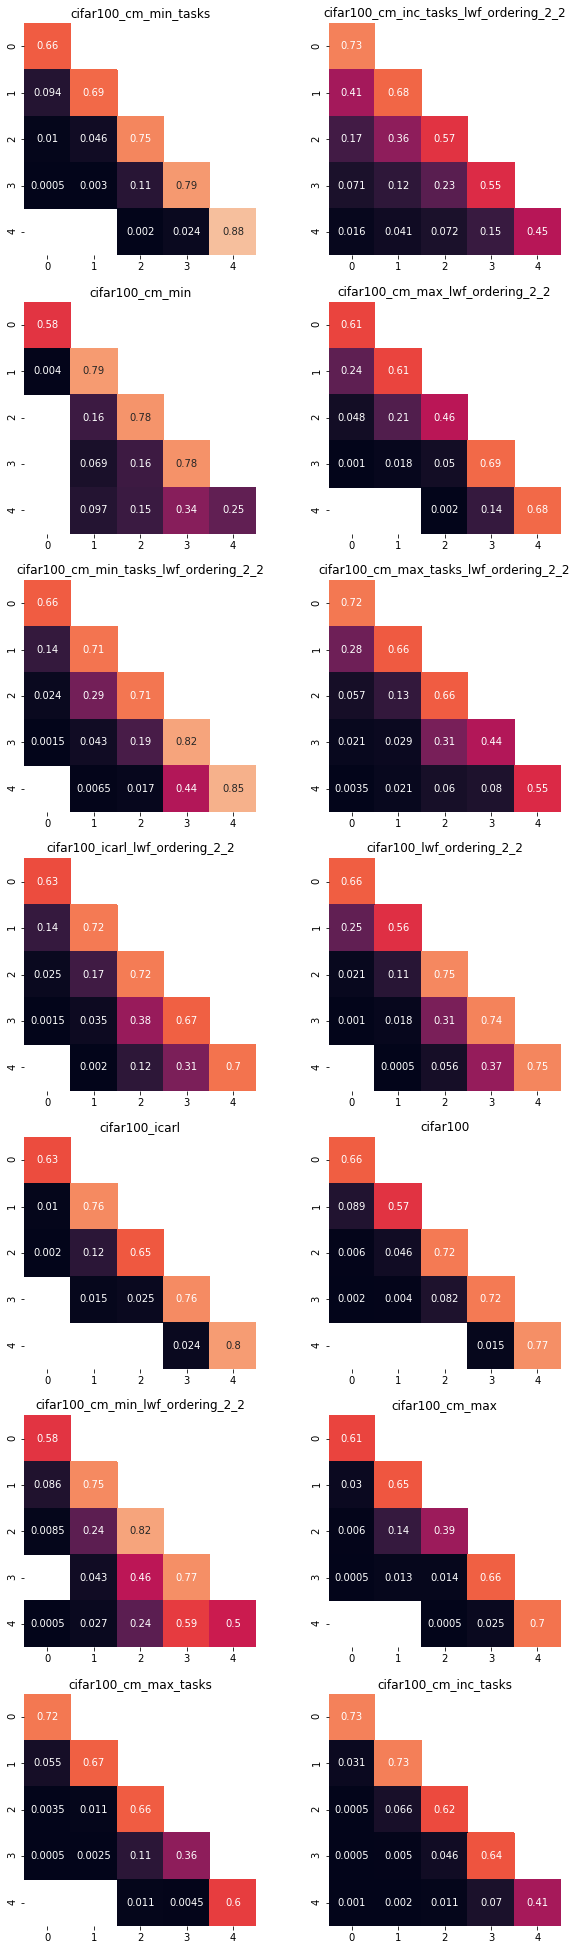

In [433]:
plt.figure(figsize=(10, len(acc)//2 * 5))

for i, (n, m) in enumerate(acc.items()):
    plt.subplot(len(acc)//2,2,i+1)
    m = np.array(m)
    mask = np.zeros_like(m)
    mask[m == 0.0] = True
#     plt.figure(figsize=(4,4))
    sns.heatmap(m, annot=True, square=True, mask=mask, cbar=False, vmin=0.0, vmax=1.0)
    plt.title(f"{n.split('_finetune')[0]}")

## Forgetting

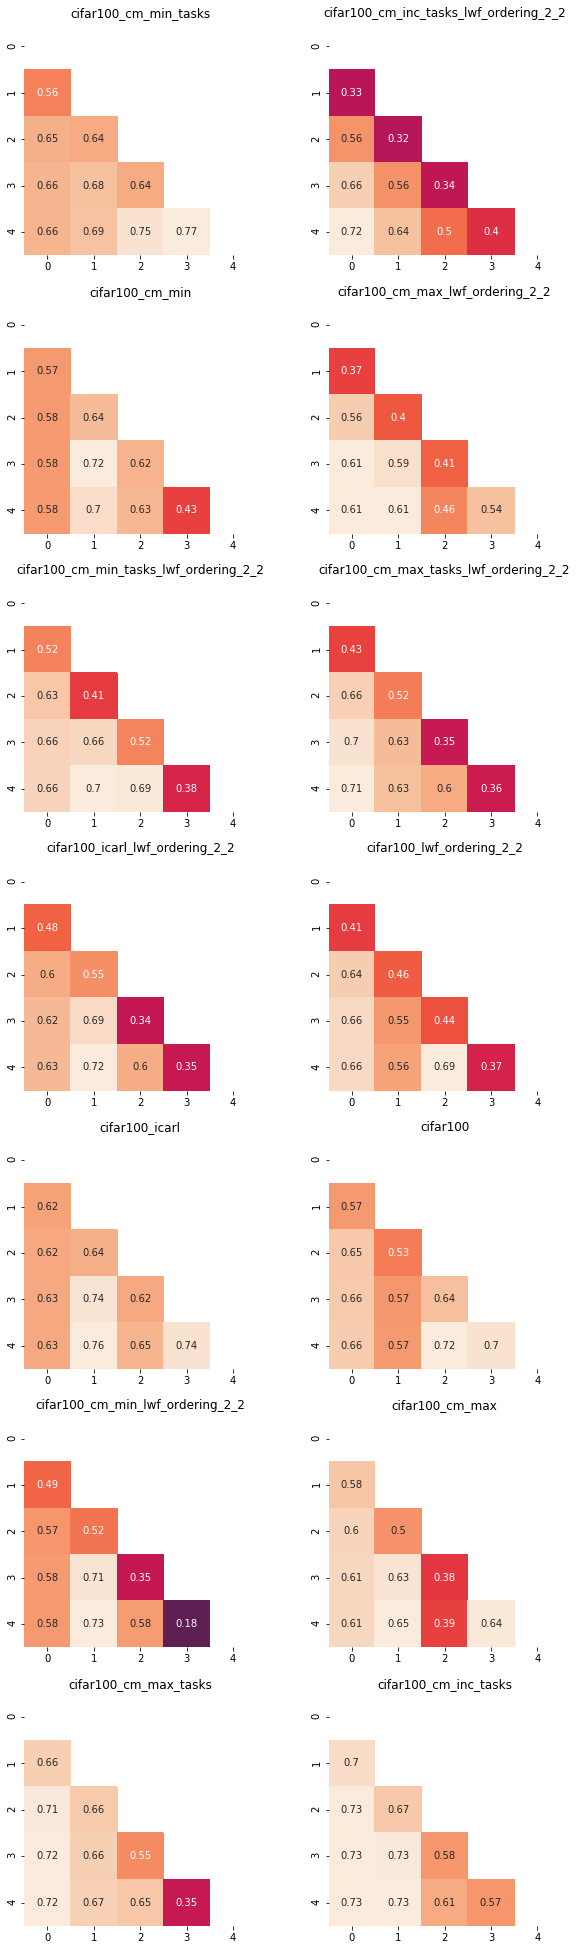

In [434]:
plt.figure(figsize=(10, len(forg)//2 * 5))

for i, (n, m) in enumerate(forg.items()):
    plt.subplot(len(acc)//2,2,i+1)
    m = np.array(m)
    mask = np.zeros_like(m)
    mask[m == 0.0] = True
#     plt.figure(figsize=(4,4))
    sns.heatmap(m, annot=True, square=True, mask=mask, cbar=False)
    plt.title(f"{n.split('_finetune')[0]}")